# Tutorial 5 - Termodinámica avanzada
### Modelación SLE usando PC-SAFT (Thymol + Octanoic acid)

In [131]:
import numpy as np
from epcsaftpy import component, pcsaft
from phasepy import nrtl
import matplotlib.pyplot as plt
from scipy import optimize
import json

**Datos experimentales y parámetros desde la siguiente referencia:**<br />
M. Martins, E. Crespo, P. Pontes, L. Silva, M. Bülow, G. Maximo, E. Batista, C. Held, S. Pinho, and J. Coutinho. ACS Sustainable Chem. Eng. 6, 8836−8846 (2018). https://doi.org/10.1021/acssuschemeng.8b01203

In [132]:
# Inicialización de los compuestos
quaternary = component('tetraethylammonium chloride', pure_path = 'parameters/solvents.json')
lauric = component('lauric acid', pure_path = 'parameters/solvents.json')

# Crear el objeto SAFT
mix = lauric + quaternary
mix.printParameters()

mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = 0.)
saft = pcsaft(mix) #Definición del objeto . nrtl, uniquac ...

# Propiedades calorimétricas
Tm1, dHm1 = 317.48, 37.83e3 # K | J/mol 
Tm2, dHm2 = 526.78, 51.24e3 # K | J/mol 
Tmi = np.array([Tm1, Tm2])
dHmi = np.array([dHm1, dHm2])

component,Mw,$ms$,$\sigma$,$\epsilon / k_B $,"[B, P, N]",$\epsilon _{AB} / k_B$,$k_{AB}$,reference
lauric acid,200.32,7.2547,3.5244,252.97,"[0, 1, 1]",3047.5,0.00338,solvents.json
tetraethylammonium chloride,165.70,17.6700,2.3510,278.06,"[0, 1, 1]",5000.0,0.10000,solvents.json


## Funciones objetivo para el SLE
Considerando que las fases sólidas cristalizan independientemente como sólidos puros y despreciando el efecto de la temperatura sobre las capacidades caloríficas, la solubilidad de un sólido en un disolvente líquido se puede describir mediante la siguiente expresión:
$$\ln(x_i \gamma_i^L) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) + \dfrac{\Delta_m C_{p,i}}{R} \left( \dfrac{T_{m,i}}{T} - \ln \dfrac{T_{m,i}}{T} - 1 \right)$$

Generalmente, el último término tiene un valor insignificante en comparación con el primero y por lo tanto no se tuvo en cuenta.
$$OF(T) = \dfrac{\Delta_m H_i}{R} \left( \dfrac{1}{T_{m,i}} - \dfrac{1}{T} \right) - \ln(x_i \gamma_i^L) $$ 

In [133]:
R = 8.31446312572960                              # [J mol-1 K-1] Constante gas
# Generamos funciones para resolver el SLE
def fobj_sle(inc, x1, P, index_comp, saft):       
    T = inc[0]
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi[index_comp]/R
    fo *= 1/Tmi[index_comp] - 1./T
    fo -= lngamma[index_comp]
    fo -= np.log(x[index_comp])
    
    return fo

# Generamos función para encontrar el punto eutéctico
def fobj_eut(inc, P, saft):                        
    x1, T = inc
    x = np.array([x1, 1 - x1])
    lngamma = saft.get_lngamma(x, T, P)

    fo = dHmi/R
    fo *= 1/Tmi - 1./T
    fo -= lngamma
    fo -= np.log(x)

    print(x1, T, fo)
    
    return fo

def fobj_sle_ideal(inc, x1, P, index_comp):       
    T = inc[0]
    x = np.array([x1, 1 - x1])
    fo = dHmi[index_comp]/R
    fo *= 1/Tmi[index_comp] - 1./T
    fo -= np.log(x[index_comp])
    
    return fo

def fobj_eut_ideal(inc, P):                        
    x1, T = inc
    x = np.array([x1, 1 - x1])
    fo = dHmi/R
    fo *= 1/Tmi - 1./T
    fo -= np.log(x)

    return fo


### Encontrando el punto eutéctico

In [134]:
P   = 1.01325e5             # Presión [Pa]
X0  = [0.65, 300.0]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft))
x1eut = out.x[0]
Teut = out.x[1]

out_2 = optimize.root(fobj_eut_ideal, X0, args = P)
x1eut_ideal = out_2.x[0]
Teut_ideal = out_2.x[1]

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
print("Composición Eutéctica  x_1E      :", round(x1eut_ideal,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut_ideal,3))

0.65 300.0 [ -1.27089872 -11.10802196]
0.65 300.0 [ -1.27089872 -11.10802196]
0.65 300.0 [ -1.27089872 -11.10802196]
0.6500000096857548 300.0 [ -1.27089869 -11.10802202]
0.65 300.00000447034836 [ -1.27089847 -11.10802155]
-0.08681653205423101 368.9329360189171 [        nan -5.13389265]


C:\Users\User\AppData\Local\Temp\ipykernel_20624\4105622918.py:24: RuntimeWarning: invalid value encountered in log
  fo -= np.log(x)


LinAlgError: Array must not contain infs or NaNs.

### Calculo del SLE

In [ ]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico

#Inicialización de variables
T0 = Tmi[1] # Temperatura de fusión del compuesto 2
x1A = np.linspace(0., x1eut, n) # Vector de composciones (fracción molar) desde 0 hasta el punto eutec
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

x1A_ideal = np.linspace(0., x1eut_ideal, n)
TA_ideal = np.zeros_like(x1A)
x1B_ideal = np.linspace(x1eut_ideal, 1., n)
TB_ideal = np.zeros_like(x1A)

#Loop de calculo ideal
for i in range(n):
    out_2 = optimize.root(fobj_sle_ideal, T0, args = (x1A_ideal[i], P, 1)) # 1 es el index del compuesto
    T0_ideal = out_2.x[0]
    TA_ideal[i] = T0_ideal
    out_2 = optimize.root(fobj_sle_ideal, T0, args = (x1B_ideal[i], P, 0))
    T0_ideal = out_2.x[0]
    TB_ideal[i] = T0_ideal
    

T0 = Tmi[1] # Temperatura de fusión del compuesto 2
x1A = np.linspace(0., x1eut, n) # Vector de composciones (fracción molar) desde 0 hasta el punto eutec
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 1 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft)) # 0 es el index del compuesto
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\association\association_aux.py:126: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xass = fsolve(fobj_xass, x0=Xass, args=(xj, aux_asso, diagasso),


### Construcción del diagrama SLE
**Datos experimentales de:** <br />
M. Martins, E. Crespo, P. Pontes, L. Silva, M. Bülow, G. Maximo, E. Batista, C. Held, S. Pinho, and J. Coutinho. ACS Sustainable Chem. Eng. 6, 8836−8846 (2018). https://doi.org/10.1021/acssuschemeng.8b01203

ValueError: x and y must be the same size

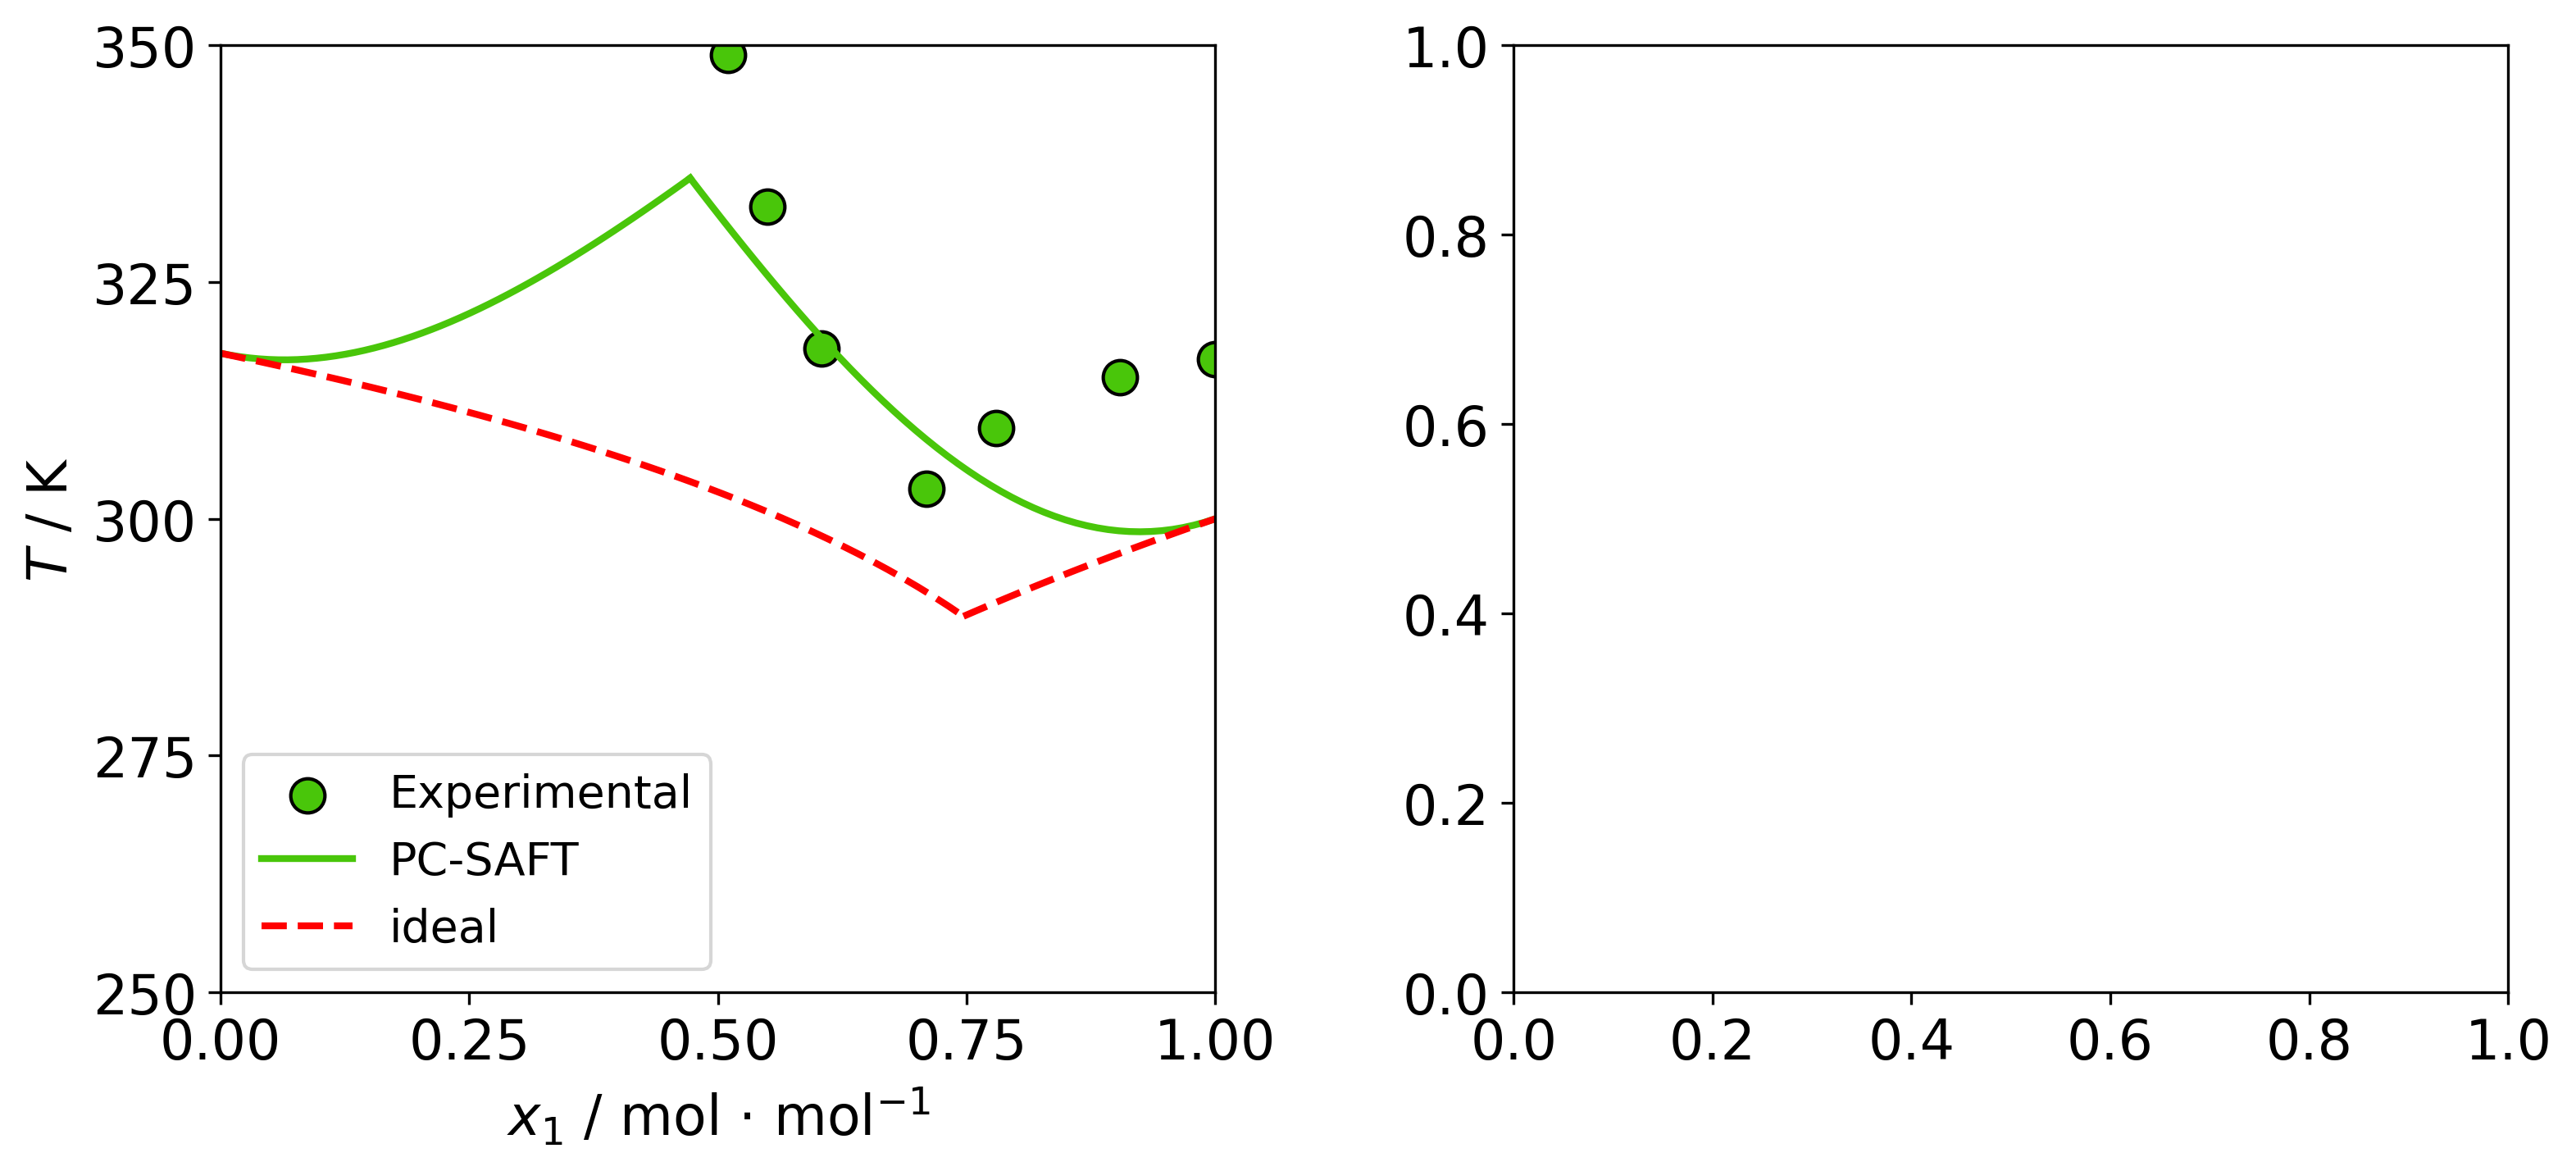

In [ ]:
          
TAexp = np.array([523.2, 492, 467, 436, 393, 349, 333, 318])           
TBexp = np.array([303.2, 309.55, 314.92, 316.875])           
x1Aexp = np.array([0, 0.11, 0.2, 0.3, 0.42, 0.51, 0.55, 0.604])
x1Bexp = np.array([0.71, 0.78, 0.904, 1])
gammA2exp = np.array([1,0.98, 0.96, 0.86, 0.86, 0.73, 0.68])
gammB1exp = np.array([0.97, 0.99, 1.02, 1])


font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1A_ideal, TA_ideal, color = "red" , 
        linewidth = 2.0, label = "ideal", linestyle='dashed')
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)
ax.plot(x1B_ideal, TB_ideal, color = "red" , 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 250., 350.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))


ax = axs[1]
color1 = "#FC7725"
color2 = "#858585"
ax.scatter(x1Aexp, gammA2exp, s = 100, c = color2, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.scatter(x1Bexp, gammB1exp, s = 100, c = color1, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1B, gamm1B, color = color1 , 
        linewidth = 2.0, label = "Componente 1")
ax.plot(x1A, gamm2A, color = color2 , 
        linewidth = 2.0, label = "Componente 2")


ax.plot([0,  1], [1, 1], color = "k", 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel(r'$\gamma_i$ ')
ax.set_xlabel(r'$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 0.6, 1.2])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()

## ¿Se puede mejorar este resultado? Ajuste de parámetros de interacción bianaria usando SLE.

In [ ]:
TAexp = np.array([523.2, 492, 467, 436, 393, 349, 333, 318])           
TBexp = np.array([303.2, 309.55, 314.92, 316.875])           
x1Aexp = np.array([0, 0.11, 0.2, 0.3, 0.42, 0.51, 0.55, 0.604])
x1Bexp = np.array([0.71, 0.78, 0.904, 1])

# fit_nrtl

def fobj_keps(X):
    kepsij0 = X[0]
    mix = quaternary + lauric
    mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = kepsij0)
    saft = pcsaft(mix)
    
    nA = len(TAexp)
    TAcal = np.zeros_like(TAexp)
    for i in range(nA):
        out = optimize.root(fobj_sle, TAexp[i], args = (x1Aexp[i], P, 1, saft))
        if out.success:
            TAcal[i] = out.x[0]
    errorA = (1 - TAcal/TAexp)
    
    nB = len(TBexp)
    TBcal = np.zeros_like(TBexp)
    for i in range(nB):
        out = optimize.root(fobj_sle, TBexp[i], args = (x1Bexp[i], P, 0, saft))
        if out.success:
            TBcal[i] = out.x[0]
    errorB = (1 - TBcal/TBexp)
    return np.append(errorA, errorB)


    

In [ ]:
method = 'lm'
out = optimize.least_squares(fobj_keps, 0., method = method)
out 

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\epcsaftpy\pcsaft_mixtures\association\association_aux.py:126: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  Xass = fsolve(fobj_xass, x0=Xass, args=(xj, aux_asso, diagasso),


     message: `ftol` termination condition is satisfied.
     success: True
      status: 2
         fun: [ 3.932e-01  3.572e-01  3.220e-01  2.718e-01  1.949e-01
                1.054e-01  6.725e-02  2.489e-02 -6.575e-01 -6.383e-01
               -6.416e-01 -6.624e-01]
           x: [-1.329e-01]
        cost: 1.102122020001954
         jac: [[ 0.000e+00]
               [-9.792e-04]
               [-5.633e-03]
               [-2.799e-02]
               [-1.929e-01]
               [-6.968e-01]
               [-9.696e-01]
               [-1.211e+00]
               [-2.091e-01]
               [-1.061e-01]
               [-1.703e-02]
               [ 0.000e+00]]
        grad: [-1.415e-05]
  optimality: 1.41537310984747e-05
 active_mask: [0]
        nfev: 14
        njev: None

### Nuevo calculo usando el valor encontrado de k_ij

In [ ]:
n = 50
# Calculo desde el componente 2 hasta el punto eutéctico
mix.set_kepsijsaft(i = 0, j = 1, kepsij0 = -2.967e-02) # Parámetro de interacción binaria


P   = 1.01325e5             # Presión [Pa]
X0  = [0.65, 300.0]         # Valores de inicialización (x0, T0) 
out = optimize.root(fobj_eut, X0, args = (P, saft))
x1eut = out.x[0]
Teut = out.x[1]

print("RESULTS")
print("_________________________________")
print("message  :", out.message)
print("success  :", out.success)
print("Composición Eutéctica  x_1E      :", round(x1eut,5))
print("Temperatura Eutéctica T_E [K]   :", round(Teut,3))
#Inicialización de variables
T0 = Tmi[1] 
x1A = np.linspace(0., x1eut, n)
TA = np.zeros_like(x1A)
gamm1A = np.zeros_like(x1A)
gamm2A = np.zeros_like(x1A)

#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1A[i], P, 1, saft))
    T0 = out.x[0]
    TA[i] = T0
    xA = np.array([x1A[i], 1 - x1A[i]])
    lngamma = saft.get_lngamma(xA, T0, P)
    gamm1A[i], gamm2A[i] = np.exp(lngamma)
    
# Calculo desde el punto eutéctico hasta el componente 2 
#Inicialización de variables
x1B = np.linspace(x1eut, 1., n)
TB = np.zeros_like(x1A)
gamm1B = np.zeros_like(x1B)
gamm2B = np.zeros_like(x1B)
#Loop de calculo
for i in range(n):
    out = optimize.root(fobj_sle, T0, args = (x1B[i], P, 0, saft))
    T0 = out.x[0]
    TB[i] = T0
    xB = np.array([x1B[i], 1 - x1B[i]])
    lngamma = saft.get_lngamma(xB, T0, P)
    gamm1B[i], gamm2B[i] = np.exp(lngamma)

[-5.27905148 -1.3737229 ]
[-5.27905148 -1.3737229 ]
[-5.27905148 -1.3737229 ]
[-5.27905144 -1.37372291]
[-5.27905127 -1.37372264]
[-2.32323701 -0.12552599]
[-2.22014852         nan]


C:\Users\User\AppData\Local\Temp\ipykernel_20624\58846338.py:24: RuntimeWarning: invalid value encountered in log
  fo -= np.log(x)


LinAlgError: Array must not contain infs or NaNs.

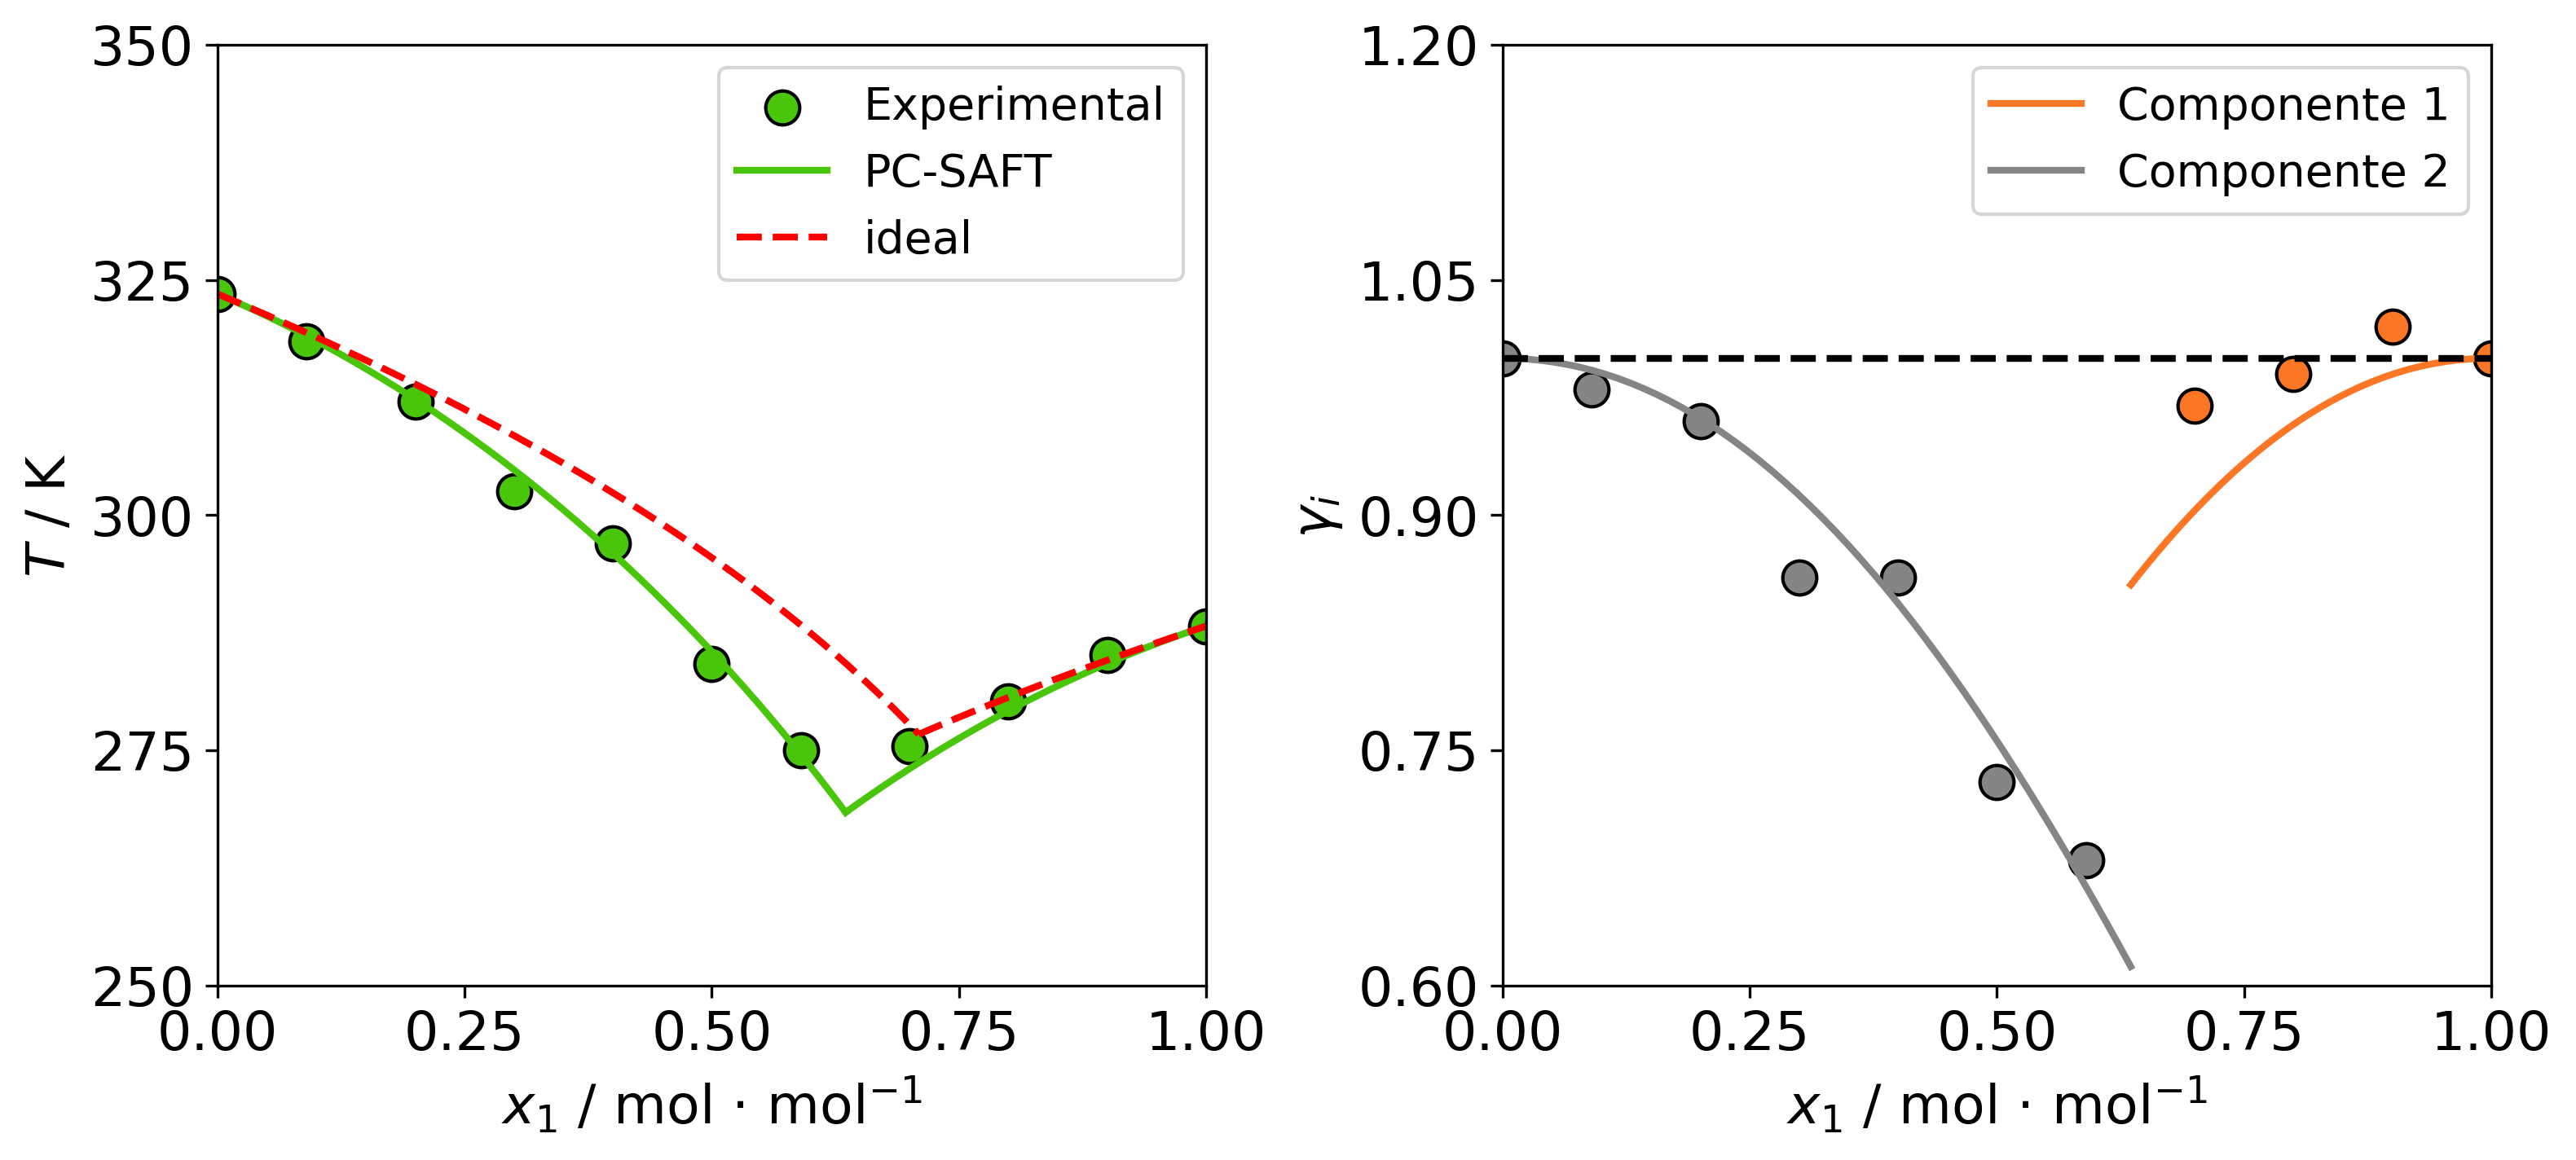

In [ ]:
TAexp = np.array([323.5, 318.49, 312.05, 302.51, 296.95, 284.16, 274.98])           
TBexp = np.array([275.45, 280.16, 285.13, 288.2])           
x1Aexp = np.array([0, 0.09, 0.2, 0.3, 0.4, 0.5, 0.59])
x1Bexp = np.array([0.7, 0.8, 0.9, 1])
gammA2exp = np.array([1,0.98, 0.96, 0.86, 0.86, 0.73, 0.68])
gammB1exp = np.array([0.97, 0.99, 1.02, 1])


font = {'weight' : 'normal',
        'size'   : 16}
plt.rc('font', **font)

colorSLE = "#49C60A"

fig, axs = plt.subplots(1,2, figsize=(12, 5), dpi = 300)
fig.subplots_adjust(hspace=0.5, wspace=0.3)

ax = axs[0]
ax.scatter(x1Aexp, TAexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k', label = "Experimental")
ax.scatter(x1Bexp, TBexp, s = 100, c = colorSLE, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1A, TA, color = colorSLE , 
        linewidth = 2.0, label = "PC-SAFT")
ax.plot(x1B, TB, color = colorSLE , 
        linewidth = 2.0)
ax.plot(x1A_ideal, TA_ideal, color = "red" , 
        linewidth = 2.0, label = "ideal", linestyle='dashed')
ax.plot(x1B_ideal, TB_ideal, color = "red" , 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel('$T$ / K')
ax.set_xlabel('$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 250., 350.])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))


ax = axs[1]
color1 = "#FC7725"
color2 = "#858585"
ax.scatter(x1Aexp, gammA2exp, s = 100, c = color2, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.scatter(x1Bexp, gammB1exp, s = 100, c = color1, marker="o", 
            linewidth=1.0, edgecolor='k')
ax.plot(x1B, gamm1B, color = color1 , 
        linewidth = 2.0, label = "Componente 1")
ax.plot(x1A, gamm2A, color = color2 , 
        linewidth = 2.0, label = "Componente 2")


ax.plot([0,  1], [1, 1], color = "k", 
        linewidth = 2.0, linestyle='dashed')

ax.legend(fontsize="small")
ax.set_ylabel(r'$\gamma_i$ ')
ax.set_xlabel(r'$x_1$ / mol $\cdot$ mol$^{-1}$')
ax.axis([0, 1., 0.6, 1.2])
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.linspace(start, end, 5))
start, end = ax.get_ylim()
ax.yaxis.set_ticks(np.linspace(start, end, 5))

plt.show()